# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [13]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [14]:
import torch

class CFG:
    print_freq=100
    num_workers=10
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/ff1010bird-duration7/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/ff1010bird-duration7/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/ff1010bird-duration7/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [16]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

In [17]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [18]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [19]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [20]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [21]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [22]:
def train_loop(train_folds, valid_folds, fold):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.CrossEntropyLoss()

    best_score = 0.
    best_loss = np.inf
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [23]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds, fold)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
========== training ==========


Epoch: [1][1/192] Data 1.912 (1.912) Elapsed 0m 2s (remain 8m 19s) Loss: 0.7186(0.7186) Grad: 53.8140  
Epoch: [1][101/192] Data 0.000 (0.020) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3741(0.5330) Grad: 11.4705  
Epoch: [1][192/192] Data 0.000 (0.011) Elapsed 1m 2s (remain 0m 0s) Loss: 0.5146(0.4679) Grad: 22.9735  
EVAL: [1/49] Data 1.116 (1.116) Elapsed 0m 1s (remain 0m 58s) Loss: 0.3245(0.3245) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6155(0.3776) 


Epoch 1 - avg_train_loss: 0.4679  avg_val_loss: 0.3776  time: 68s
Epoch 1 - avg_train_loss: 0.4679  avg_val_loss: 0.3776  time: 68s
Epoch 1 - Accuracy: 0.8498049414824448
Epoch 1 - Accuracy: 0.8498049414824448
Epoch 1 - Save Best Score: 0.8498 Model
Epoch 1 - Save Best Score: 0.8498 Model


Epoch: [2][1/192] Data 2.238 (2.238) Elapsed 0m 2s (remain 8m 46s) Loss: 0.2676(0.2676) Grad: 18.7411  
Epoch: [2][101/192] Data 0.000 (0.023) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2525(0.3479) Grad: 11.6555  
Epoch: [2][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3981(0.3346) Grad: 16.4286  
EVAL: [1/49] Data 1.135 (1.135) Elapsed 0m 1s (remain 1m 0s) Loss: 0.2876(0.2876) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3633(0.3366) 


Epoch 2 - avg_train_loss: 0.3346  avg_val_loss: 0.3366  time: 67s
Epoch 2 - avg_train_loss: 0.3346  avg_val_loss: 0.3366  time: 67s
Epoch 2 - Accuracy: 0.8803641092327699
Epoch 2 - Accuracy: 0.8803641092327699
Epoch 2 - Save Best Score: 0.8804 Model
Epoch 2 - Save Best Score: 0.8804 Model


Epoch: [3][1/192] Data 2.198 (2.198) Elapsed 0m 2s (remain 8m 40s) Loss: 0.2096(0.2096) Grad: 10.2873  
Epoch: [3][101/192] Data 0.000 (0.023) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2183(0.3081) Grad: 8.7971  
Epoch: [3][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2957(0.2920) Grad: 13.8818  
EVAL: [1/49] Data 0.767 (0.767) Elapsed 0m 0s (remain 0m 46s) Loss: 0.3074(0.3074) 


Epoch 3 - avg_train_loss: 0.2920  avg_val_loss: 0.3286  time: 68s


EVAL: [49/49] Data 0.000 (0.016) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3334(0.3286) 


Epoch 3 - avg_train_loss: 0.2920  avg_val_loss: 0.3286  time: 68s
Epoch 3 - Accuracy: 0.881664499349805
Epoch 3 - Accuracy: 0.881664499349805
Epoch 3 - Save Best Score: 0.8817 Model
Epoch 3 - Save Best Score: 0.8817 Model


Epoch: [4][1/192] Data 2.596 (2.596) Elapsed 0m 3s (remain 10m 24s) Loss: 0.2248(0.2248) Grad: 11.6576  
Epoch: [4][101/192] Data 0.001 (0.027) Elapsed 0m 34s (remain 0m 31s) Loss: 0.1921(0.2661) Grad: 10.9884  
Epoch: [4][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2774(0.2528) Grad: 11.6220  
EVAL: [1/49] Data 0.846 (0.846) Elapsed 0m 1s (remain 0m 48s) Loss: 0.3293(0.3293) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2267(0.3443) 


Epoch 4 - avg_train_loss: 0.2528  avg_val_loss: 0.3443  time: 68s
Epoch 4 - avg_train_loss: 0.2528  avg_val_loss: 0.3443  time: 68s
Epoch 4 - Accuracy: 0.8810143042912874
Epoch 4 - Accuracy: 0.8810143042912874


Epoch: [5][1/192] Data 2.369 (2.369) Elapsed 0m 2s (remain 9m 19s) Loss: 0.1841(0.1841) Grad: 11.1719  
Epoch: [5][101/192] Data 0.001 (0.024) Elapsed 0m 34s (remain 0m 31s) Loss: 0.1936(0.2353) Grad: 10.1687  
Epoch: [5][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2139(0.2184) Grad: 9.0005  
EVAL: [1/49] Data 0.789 (0.789) Elapsed 0m 0s (remain 0m 47s) Loss: 0.4164(0.4164) 
EVAL: [49/49] Data 0.000 (0.017) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2137(0.3438) 


Epoch 5 - avg_train_loss: 0.2184  avg_val_loss: 0.3438  time: 68s
Epoch 5 - avg_train_loss: 0.2184  avg_val_loss: 0.3438  time: 68s
Epoch 5 - Accuracy: 0.8842652795838751
Epoch 5 - Accuracy: 0.8842652795838751
Epoch 5 - Save Best Score: 0.8843 Model
Epoch 5 - Save Best Score: 0.8843 Model


Epoch: [6][1/192] Data 2.735 (2.735) Elapsed 0m 3s (remain 10m 38s) Loss: 0.1707(0.1707) Grad: 9.7492  
Epoch: [6][101/192] Data 0.001 (0.028) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2200(0.2036) Grad: 17.8721  
Epoch: [6][192/192] Data 0.000 (0.015) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1660(0.1922) Grad: 8.4097  
EVAL: [1/49] Data 1.136 (1.136) Elapsed 0m 1s (remain 0m 59s) Loss: 0.3875(0.3875) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1562(0.3480) 


Epoch 6 - avg_train_loss: 0.1922  avg_val_loss: 0.3480  time: 68s
Epoch 6 - avg_train_loss: 0.1922  avg_val_loss: 0.3480  time: 68s
Epoch 6 - Accuracy: 0.8875162548764629
Epoch 6 - Accuracy: 0.8875162548764629
Epoch 6 - Save Best Score: 0.8875 Model
Epoch 6 - Save Best Score: 0.8875 Model


Epoch: [7][1/192] Data 2.085 (2.085) Elapsed 0m 2s (remain 8m 14s) Loss: 0.0915(0.0915) Grad: 7.2383  
Epoch: [7][101/192] Data 0.000 (0.021) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1364(0.1725) Grad: 11.3208  
Epoch: [7][192/192] Data 0.000 (0.011) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2289(0.1578) Grad: 19.7663  
EVAL: [1/49] Data 0.872 (0.872) Elapsed 0m 1s (remain 0m 50s) Loss: 0.4579(0.4579) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0610(0.3639) 


Epoch 7 - avg_train_loss: 0.1578  avg_val_loss: 0.3639  time: 67s
Epoch 7 - avg_train_loss: 0.1578  avg_val_loss: 0.3639  time: 67s
Epoch 7 - Accuracy: 0.8836150845253576
Epoch 7 - Accuracy: 0.8836150845253576


Epoch: [8][1/192] Data 1.581 (1.581) Elapsed 0m 2s (remain 6m 36s) Loss: 0.0832(0.0832) Grad: 7.8398  
Epoch: [8][101/192] Data 0.001 (0.022) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1147(0.1516) Grad: 8.3709  
Epoch: [8][192/192] Data 0.000 (0.012) Elapsed 1m 1s (remain 0m 0s) Loss: 0.2332(0.1409) Grad: 13.7087  
EVAL: [1/49] Data 0.829 (0.829) Elapsed 0m 0s (remain 0m 45s) Loss: 0.4428(0.4428) 
EVAL: [49/49] Data 0.000 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0994(0.3669) 


Epoch 8 - avg_train_loss: 0.1409  avg_val_loss: 0.3669  time: 67s
Epoch 8 - avg_train_loss: 0.1409  avg_val_loss: 0.3669  time: 67s
Epoch 8 - Accuracy: 0.8875162548764629
Epoch 8 - Accuracy: 0.8875162548764629


Epoch: [9][1/192] Data 1.789 (1.789) Elapsed 0m 2s (remain 7m 21s) Loss: 0.0815(0.0815) Grad: 7.5758  
Epoch: [9][101/192] Data 0.001 (0.019) Elapsed 0m 34s (remain 0m 30s) Loss: 0.0762(0.1296) Grad: 7.8994  
Epoch: [9][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1076(0.1179) Grad: 10.6209  
EVAL: [1/49] Data 0.729 (0.729) Elapsed 0m 0s (remain 0m 44s) Loss: 0.4262(0.4262) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0778(0.3718) 


Epoch 9 - avg_train_loss: 0.1179  avg_val_loss: 0.3718  time: 67s
Epoch 9 - avg_train_loss: 0.1179  avg_val_loss: 0.3718  time: 67s
Epoch 9 - Accuracy: 0.8868660598179454
Epoch 9 - Accuracy: 0.8868660598179454


Epoch: [10][1/192] Data 1.634 (1.634) Elapsed 0m 2s (remain 6m 51s) Loss: 0.1157(0.1157) Grad: 12.7450  
Epoch: [10][101/192] Data 0.000 (0.017) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1071(0.1259) Grad: 11.0559  
Epoch: [10][192/192] Data 0.000 (0.009) Elapsed 1m 1s (remain 0m 0s) Loss: 0.1406(0.1125) Grad: 10.5541  
EVAL: [1/49] Data 1.153 (1.153) Elapsed 0m 1s (remain 1m 0s) Loss: 0.4291(0.4291) 


Epoch 10 - avg_train_loss: 0.1125  avg_val_loss: 0.3740  time: 67s
Epoch 10 - avg_train_loss: 0.1125  avg_val_loss: 0.3740  time: 67s


EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0734(0.3740) 


Epoch 10 - Accuracy: 0.8849154746423927
Epoch 10 - Accuracy: 0.8849154746423927
========== CV ==========
========== CV ==========
Score: 0.88752
Score: 0.88752


TN 1111
FP 40
FN 133
TP 254


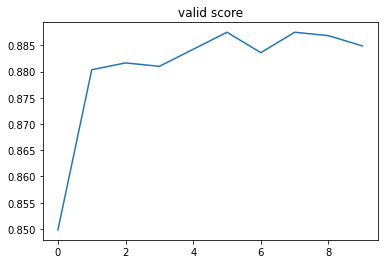

========== training ==========
========== training ==========


Epoch: [1][1/192] Data 2.422 (2.422) Elapsed 0m 3s (remain 9m 46s) Loss: 0.6632(0.6632) Grad: 27.0017  
Epoch: [1][101/192] Data 0.000 (0.025) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3432(0.5308) Grad: 15.8543  
Epoch: [1][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4176(0.4670) Grad: 20.4853  
EVAL: [1/49] Data 0.673 (0.673) Elapsed 0m 0s (remain 0m 41s) Loss: 0.3408(0.3408) 
EVAL: [49/49] Data 0.000 (0.015) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0725(0.3595) 


Epoch 1 - avg_train_loss: 0.4670  avg_val_loss: 0.3595  time: 68s
Epoch 1 - avg_train_loss: 0.4670  avg_val_loss: 0.3595  time: 68s
Epoch 1 - Accuracy: 0.8550065019505851
Epoch 1 - Accuracy: 0.8550065019505851
Epoch 1 - Save Best Score: 0.8550 Model
Epoch 1 - Save Best Score: 0.8550 Model


Epoch: [2][1/192] Data 1.450 (1.450) Elapsed 0m 1s (remain 6m 10s) Loss: 0.2911(0.2911) Grad: 15.3104  
Epoch: [2][101/192] Data 0.000 (0.015) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3488(0.3509) Grad: 18.5063  
Epoch: [2][192/192] Data 0.000 (0.008) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3143(0.3354) Grad: 18.6293  
EVAL: [1/49] Data 1.006 (1.006) Elapsed 0m 1s (remain 0m 55s) Loss: 0.3115(0.3115) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1635(0.3127) 


Epoch 2 - avg_train_loss: 0.3354  avg_val_loss: 0.3127  time: 68s
Epoch 2 - avg_train_loss: 0.3354  avg_val_loss: 0.3127  time: 68s
Epoch 2 - Accuracy: 0.8836150845253576
Epoch 2 - Accuracy: 0.8836150845253576
Epoch 2 - Save Best Score: 0.8836 Model
Epoch 2 - Save Best Score: 0.8836 Model


Epoch: [3][1/192] Data 2.253 (2.253) Elapsed 0m 3s (remain 9m 51s) Loss: 0.2540(0.2540) Grad: 11.0362  
Epoch: [3][101/192] Data 0.001 (0.023) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3333(0.3078) Grad: 16.3124  
Epoch: [3][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4092(0.2964) Grad: 21.1164  
EVAL: [1/49] Data 0.918 (0.918) Elapsed 0m 1s (remain 0m 54s) Loss: 0.2677(0.2677) 
EVAL: [49/49] Data 0.000 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2459(0.2849) 


Epoch 3 - avg_train_loss: 0.2964  avg_val_loss: 0.2849  time: 68s
Epoch 3 - avg_train_loss: 0.2964  avg_val_loss: 0.2849  time: 68s
Epoch 3 - Accuracy: 0.893368010403121
Epoch 3 - Accuracy: 0.893368010403121
Epoch 3 - Save Best Score: 0.8934 Model
Epoch 3 - Save Best Score: 0.8934 Model


Epoch: [4][1/192] Data 1.682 (1.682) Elapsed 0m 2s (remain 7m 19s) Loss: 0.1785(0.1785) Grad: 9.7583  
Epoch: [4][101/192] Data 0.001 (0.018) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3535(0.2796) Grad: 17.3286  
Epoch: [4][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2417(0.2671) Grad: 20.7898  
EVAL: [1/49] Data 0.944 (0.944) Elapsed 0m 1s (remain 0m 54s) Loss: 0.2397(0.2397) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2222(0.2771) 


Epoch 4 - avg_train_loss: 0.2671  avg_val_loss: 0.2771  time: 68s
Epoch 4 - avg_train_loss: 0.2671  avg_val_loss: 0.2771  time: 68s
Epoch 4 - Accuracy: 0.9063719115734721
Epoch 4 - Accuracy: 0.9063719115734721
Epoch 4 - Save Best Score: 0.9064 Model
Epoch 4 - Save Best Score: 0.9064 Model


Epoch: [5][1/192] Data 1.673 (1.673) Elapsed 0m 2s (remain 7m 9s) Loss: 0.1837(0.1837) Grad: 13.0395  
Epoch: [5][101/192] Data 0.000 (0.017) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2058(0.2476) Grad: 11.0446  
Epoch: [5][192/192] Data 0.000 (0.009) Elapsed 1m 1s (remain 0m 0s) Loss: 0.2061(0.2371) Grad: 12.4072  
EVAL: [1/49] Data 0.992 (0.992) Elapsed 0m 1s (remain 0m 55s) Loss: 0.2413(0.2413) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.4333(0.2813) 


Epoch 5 - avg_train_loss: 0.2371  avg_val_loss: 0.2813  time: 67s
Epoch 5 - avg_train_loss: 0.2371  avg_val_loss: 0.2813  time: 67s
Epoch 5 - Accuracy: 0.8992197659297789
Epoch 5 - Accuracy: 0.8992197659297789


Epoch: [6][1/192] Data 1.687 (1.687) Elapsed 0m 2s (remain 7m 25s) Loss: 0.2263(0.2263) Grad: 14.7311  
Epoch: [6][101/192] Data 0.000 (0.017) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3032(0.2255) Grad: 20.2067  
Epoch: [6][192/192] Data 0.000 (0.009) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3761(0.2109) Grad: 20.8980  
EVAL: [1/49] Data 0.985 (0.985) Elapsed 0m 1s (remain 0m 55s) Loss: 0.2906(0.2906) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3758(0.2687) 


Epoch 6 - avg_train_loss: 0.2109  avg_val_loss: 0.2687  time: 67s
Epoch 6 - avg_train_loss: 0.2109  avg_val_loss: 0.2687  time: 67s
Epoch 6 - Accuracy: 0.8985695708712613
Epoch 6 - Accuracy: 0.8985695708712613


Epoch: [7][1/192] Data 1.815 (1.815) Elapsed 0m 2s (remain 7m 35s) Loss: 0.1287(0.1287) Grad: 7.5114  
Epoch: [7][101/192] Data 0.000 (0.019) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2288(0.1938) Grad: 20.7849  
Epoch: [7][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2525(0.1790) Grad: 21.5492  
EVAL: [1/49] Data 0.779 (0.779) Elapsed 0m 0s (remain 0m 44s) Loss: 0.2479(0.2479) 
EVAL: [49/49] Data 0.000 (0.017) Elapsed 0m 4s (remain 0m 0s) Loss: 0.6402(0.2864) 


Epoch 7 - avg_train_loss: 0.1790  avg_val_loss: 0.2864  time: 68s
Epoch 7 - avg_train_loss: 0.1790  avg_val_loss: 0.2864  time: 68s
Epoch 7 - Accuracy: 0.8946684005201561
Epoch 7 - Accuracy: 0.8946684005201561


Epoch: [8][1/192] Data 2.673 (2.673) Elapsed 0m 3s (remain 9m 56s) Loss: 0.1614(0.1614) Grad: 11.1249  
Epoch: [8][101/192] Data 0.000 (0.027) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2512(0.1701) Grad: 19.9495  
Epoch: [8][192/192] Data 0.000 (0.015) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3212(0.1559) Grad: 33.0646  
EVAL: [1/49] Data 0.867 (0.867) Elapsed 0m 1s (remain 0m 51s) Loss: 0.2892(0.2892) 


Epoch 8 - avg_train_loss: 0.1559  avg_val_loss: 0.2882  time: 68s
Epoch 8 - avg_train_loss: 0.1559  avg_val_loss: 0.2882  time: 68s


EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5532(0.2882) 


Epoch 8 - Accuracy: 0.900520156046814
Epoch 8 - Accuracy: 0.900520156046814


Epoch: [9][1/192] Data 2.283 (2.283) Elapsed 0m 2s (remain 8m 47s) Loss: 0.1470(0.1470) Grad: 13.2522  
Epoch: [9][101/192] Data 0.000 (0.024) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1826(0.1569) Grad: 19.6079  
Epoch: [9][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1647(0.1439) Grad: 13.5074  
EVAL: [1/49] Data 0.914 (0.914) Elapsed 0m 1s (remain 0m 58s) Loss: 0.3274(0.3274) 
EVAL: [49/49] Data 0.000 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5724(0.2853) 


Epoch 9 - avg_train_loss: 0.1439  avg_val_loss: 0.2853  time: 68s
Epoch 9 - avg_train_loss: 0.1439  avg_val_loss: 0.2853  time: 68s
Epoch 9 - Accuracy: 0.9011703511053316
Epoch 9 - Accuracy: 0.9011703511053316


Epoch: [10][1/192] Data 2.355 (2.355) Elapsed 0m 2s (remain 9m 9s) Loss: 0.1207(0.1207) Grad: 11.0496  
Epoch: [10][101/192] Data 0.000 (0.024) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1523(0.1405) Grad: 10.4002  
Epoch: [10][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1798(0.1320) Grad: 16.4913  
EVAL: [1/49] Data 0.816 (0.816) Elapsed 0m 1s (remain 0m 51s) Loss: 0.3236(0.3236) 
EVAL: [49/49] Data 0.000 (0.017) Elapsed 0m 4s (remain 0m 0s) Loss: 0.5183(0.2906) 


Epoch 10 - avg_train_loss: 0.1320  avg_val_loss: 0.2906  time: 67s
Epoch 10 - avg_train_loss: 0.1320  avg_val_loss: 0.2906  time: 67s
Epoch 10 - Accuracy: 0.8966189856957087
Epoch 10 - Accuracy: 0.8966189856957087
========== CV ==========
========== CV ==========
Score: 0.90637
Score: 0.90637


TN 1124
FP 27
FN 117
TP 270


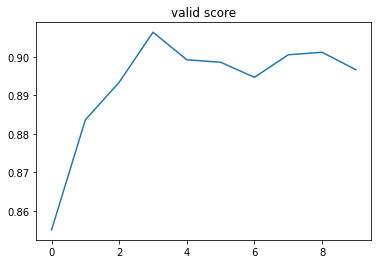

========== training ==========
========== training ==========


Epoch: [1][1/192] Data 1.854 (1.854) Elapsed 0m 2s (remain 7m 19s) Loss: 0.7061(0.7061) Grad: 30.8947  
Epoch: [1][101/192] Data 0.000 (0.019) Elapsed 0m 34s (remain 0m 30s) Loss: 0.4236(0.5285) Grad: 22.4790  
Epoch: [1][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4721(0.4629) Grad: 18.3414  
EVAL: [1/49] Data 0.867 (0.867) Elapsed 0m 0s (remain 0m 47s) Loss: 0.5290(0.5290) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1297(0.3639) 


Epoch 1 - avg_train_loss: 0.4629  avg_val_loss: 0.3639  time: 67s
Epoch 1 - avg_train_loss: 0.4629  avg_val_loss: 0.3639  time: 67s
Epoch 1 - Accuracy: 0.8647594278283485
Epoch 1 - Accuracy: 0.8647594278283485
Epoch 1 - Save Best Score: 0.8648 Model
Epoch 1 - Save Best Score: 0.8648 Model


Epoch: [2][1/192] Data 2.226 (2.226) Elapsed 0m 2s (remain 8m 50s) Loss: 0.2772(0.2772) Grad: 15.5760  
Epoch: [2][101/192] Data 0.001 (0.023) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3429(0.3501) Grad: 13.6594  
Epoch: [2][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4576(0.3291) Grad: 24.6057  
EVAL: [1/49] Data 0.893 (0.893) Elapsed 0m 1s (remain 0m 51s) Loss: 0.6023(0.6023) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0804(0.3387) 


Epoch 2 - avg_train_loss: 0.3291  avg_val_loss: 0.3387  time: 67s
Epoch 2 - avg_train_loss: 0.3291  avg_val_loss: 0.3387  time: 67s
Epoch 2 - Accuracy: 0.8706111833550065
Epoch 2 - Accuracy: 0.8706111833550065
Epoch 2 - Save Best Score: 0.8706 Model
Epoch 2 - Save Best Score: 0.8706 Model


Epoch: [3][1/192] Data 2.498 (2.498) Elapsed 0m 3s (remain 9m 53s) Loss: 0.2091(0.2091) Grad: 10.9472  
Epoch: [3][101/192] Data 0.000 (0.025) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2896(0.3060) Grad: 17.5288  
Epoch: [3][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4404(0.2871) Grad: 18.6193  
EVAL: [1/49] Data 1.001 (1.001) Elapsed 0m 1s (remain 0m 56s) Loss: 0.4575(0.4575) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0432(0.3196) 


Epoch 3 - avg_train_loss: 0.2871  avg_val_loss: 0.3196  time: 68s
Epoch 3 - avg_train_loss: 0.2871  avg_val_loss: 0.3196  time: 68s
Epoch 3 - Accuracy: 0.8784135240572172
Epoch 3 - Accuracy: 0.8784135240572172
Epoch 3 - Save Best Score: 0.8784 Model
Epoch 3 - Save Best Score: 0.8784 Model


Epoch: [4][1/192] Data 1.736 (1.736) Elapsed 0m 2s (remain 7m 3s) Loss: 0.1688(0.1688) Grad: 9.7211  
Epoch: [4][101/192] Data 0.000 (0.018) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2633(0.2854) Grad: 21.6061  
Epoch: [4][192/192] Data 0.000 (0.010) Elapsed 1m 1s (remain 0m 0s) Loss: 0.3576(0.2742) Grad: 19.7315  
EVAL: [1/49] Data 1.010 (1.010) Elapsed 0m 1s (remain 0m 57s) Loss: 0.6235(0.6235) 
EVAL: [49/49] Data 0.000 (0.021) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0168(0.3163) 


Epoch 4 - avg_train_loss: 0.2742  avg_val_loss: 0.3163  time: 67s
Epoch 4 - avg_train_loss: 0.2742  avg_val_loss: 0.3163  time: 67s
Epoch 4 - Accuracy: 0.8849154746423927
Epoch 4 - Accuracy: 0.8849154746423927
Epoch 4 - Save Best Score: 0.8849 Model
Epoch 4 - Save Best Score: 0.8849 Model


Epoch: [5][1/192] Data 2.318 (2.318) Elapsed 0m 2s (remain 8m 59s) Loss: 0.1879(0.1879) Grad: 11.8807  
Epoch: [5][101/192] Data 0.000 (0.024) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2376(0.2581) Grad: 12.7268  
Epoch: [5][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2962(0.2427) Grad: 13.8029  
EVAL: [1/49] Data 0.700 (0.700) Elapsed 0m 0s (remain 0m 37s) Loss: 0.4922(0.4922) 


Epoch 5 - avg_train_loss: 0.2427  avg_val_loss: 0.3088  time: 68s
Epoch 5 - avg_train_loss: 0.2427  avg_val_loss: 0.3088  time: 68s


EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0177(0.3088) 


Epoch 5 - Accuracy: 0.8823146944083224
Epoch 5 - Accuracy: 0.8823146944083224


Epoch: [6][1/192] Data 1.681 (1.681) Elapsed 0m 2s (remain 7m 33s) Loss: 0.1476(0.1476) Grad: 7.9806  
Epoch: [6][101/192] Data 0.000 (0.018) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2056(0.2256) Grad: 19.8053  
Epoch: [6][192/192] Data 0.000 (0.009) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2039(0.2128) Grad: 10.0768  
EVAL: [1/49] Data 1.092 (1.092) Elapsed 0m 1s (remain 0m 59s) Loss: 0.5829(0.5829) 
EVAL: [49/49] Data 0.000 (0.023) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0178(0.3102) 


Epoch 6 - avg_train_loss: 0.2128  avg_val_loss: 0.3102  time: 68s
Epoch 6 - avg_train_loss: 0.2128  avg_val_loss: 0.3102  time: 68s
Epoch 6 - Accuracy: 0.8849154746423927
Epoch 6 - Accuracy: 0.8849154746423927


Epoch: [7][1/192] Data 2.188 (2.188) Elapsed 0m 2s (remain 8m 54s) Loss: 0.1279(0.1279) Grad: 7.7721  
Epoch: [7][101/192] Data 0.001 (0.026) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2121(0.2002) Grad: 8.8023  
Epoch: [7][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2438(0.1856) Grad: 15.4110  
EVAL: [1/49] Data 0.860 (0.860) Elapsed 0m 1s (remain 0m 51s) Loss: 0.5600(0.5600) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0091(0.3228) 


Epoch 7 - avg_train_loss: 0.1856  avg_val_loss: 0.3228  time: 68s
Epoch 7 - avg_train_loss: 0.1856  avg_val_loss: 0.3228  time: 68s
Epoch 7 - Accuracy: 0.8849154746423927
Epoch 7 - Accuracy: 0.8849154746423927


Epoch: [8][1/192] Data 2.409 (2.409) Elapsed 0m 2s (remain 9m 27s) Loss: 0.1475(0.1475) Grad: 13.6694  
Epoch: [8][101/192] Data 0.000 (0.025) Elapsed 0m 34s (remain 0m 31s) Loss: 0.1519(0.1750) Grad: 13.1821  
Epoch: [8][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3554(0.1618) Grad: 17.6200  
EVAL: [1/49] Data 0.943 (0.943) Elapsed 0m 1s (remain 0m 55s) Loss: 0.5784(0.5784) 
EVAL: [49/49] Data 0.000 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0060(0.3223) 


Epoch 8 - avg_train_loss: 0.1618  avg_val_loss: 0.3223  time: 68s
Epoch 8 - avg_train_loss: 0.1618  avg_val_loss: 0.3223  time: 68s
Epoch 8 - Accuracy: 0.8868660598179454
Epoch 8 - Accuracy: 0.8868660598179454
Epoch 8 - Save Best Score: 0.8869 Model
Epoch 8 - Save Best Score: 0.8869 Model


Epoch: [9][1/192] Data 2.112 (2.112) Elapsed 0m 2s (remain 8m 34s) Loss: 0.1003(0.1003) Grad: 9.7742  
Epoch: [9][101/192] Data 0.000 (0.022) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2455(0.1547) Grad: 12.5933  
Epoch: [9][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2405(0.1445) Grad: 19.9307  
EVAL: [1/49] Data 0.653 (0.653) Elapsed 0m 0s (remain 0m 38s) Loss: 0.6148(0.6148) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0051(0.3274) 


Epoch 9 - avg_train_loss: 0.1445  avg_val_loss: 0.3274  time: 67s
Epoch 9 - avg_train_loss: 0.1445  avg_val_loss: 0.3274  time: 67s
Epoch 9 - Accuracy: 0.8823146944083224
Epoch 9 - Accuracy: 0.8823146944083224


Epoch: [10][1/192] Data 2.123 (2.123) Elapsed 0m 2s (remain 8m 22s) Loss: 0.0882(0.0882) Grad: 6.9575  
Epoch: [10][101/192] Data 0.003 (0.022) Elapsed 0m 34s (remain 0m 31s) Loss: 0.1578(0.1519) Grad: 11.8794  
Epoch: [10][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2374(0.1413) Grad: 17.4074  
EVAL: [1/49] Data 1.051 (1.051) Elapsed 0m 1s (remain 0m 57s) Loss: 0.6077(0.6077) 
EVAL: [49/49] Data 0.000 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0034(0.3319) 


Epoch 10 - avg_train_loss: 0.1413  avg_val_loss: 0.3319  time: 68s
Epoch 10 - avg_train_loss: 0.1413  avg_val_loss: 0.3319  time: 68s
Epoch 10 - Accuracy: 0.8881664499349805
Epoch 10 - Accuracy: 0.8881664499349805
Epoch 10 - Save Best Score: 0.8882 Model
Epoch 10 - Save Best Score: 0.8882 Model
========== CV ==========
========== CV ==========
Score: 0.88817
Score: 0.88817


TN 1107
FP 44
FN 128
TP 259


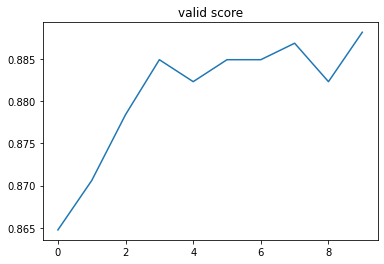

========== training ==========
========== training ==========


Epoch: [1][1/192] Data 2.123 (2.123) Elapsed 0m 2s (remain 8m 30s) Loss: 0.7014(0.7014) Grad: 37.8511  
Epoch: [1][101/192] Data 0.000 (0.022) Elapsed 0m 34s (remain 0m 30s) Loss: 0.4006(0.5437) Grad: 19.2934  
Epoch: [1][192/192] Data 0.000 (0.012) Elapsed 1m 1s (remain 0m 0s) Loss: 0.3510(0.4751) Grad: 16.2508  
EVAL: [1/49] Data 0.927 (0.927) Elapsed 0m 1s (remain 0m 51s) Loss: 0.4041(0.4041) 


Epoch 1 - avg_train_loss: 0.4751  avg_val_loss: 0.3596  time: 67s


EVAL: [49/49] Data 0.000 (0.020) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2338(0.3596) 


Epoch 1 - avg_train_loss: 0.4751  avg_val_loss: 0.3596  time: 67s
Epoch 1 - Accuracy: 0.8621586475942783
Epoch 1 - Accuracy: 0.8621586475942783
Epoch 1 - Save Best Score: 0.8622 Model
Epoch 1 - Save Best Score: 0.8622 Model


Epoch: [2][1/192] Data 1.783 (1.783) Elapsed 0m 2s (remain 7m 39s) Loss: 0.3805(0.3805) Grad: 21.4509  
Epoch: [2][101/192] Data 0.000 (0.019) Elapsed 0m 34s (remain 0m 30s) Loss: 0.4872(0.3596) Grad: 17.0321  
Epoch: [2][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3008(0.3406) Grad: 16.2321  
EVAL: [1/49] Data 1.187 (1.187) Elapsed 0m 1s (remain 1m 0s) Loss: 0.4187(0.4187) 
EVAL: [49/49] Data 0.000 (0.025) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1064(0.3183) 


Epoch 2 - avg_train_loss: 0.3406  avg_val_loss: 0.3183  time: 68s
Epoch 2 - avg_train_loss: 0.3406  avg_val_loss: 0.3183  time: 68s
Epoch 2 - Accuracy: 0.8881664499349805
Epoch 2 - Accuracy: 0.8881664499349805
Epoch 2 - Save Best Score: 0.8882 Model
Epoch 2 - Save Best Score: 0.8882 Model


Epoch: [3][1/192] Data 2.674 (2.674) Elapsed 0m 3s (remain 9m 51s) Loss: 0.2691(0.2691) Grad: 11.6551  
Epoch: [3][101/192] Data 0.000 (0.027) Elapsed 0m 34s (remain 0m 31s) Loss: 0.4359(0.3178) Grad: 15.1329  
Epoch: [3][192/192] Data 0.000 (0.015) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2539(0.3055) Grad: 12.2150  
EVAL: [1/49] Data 1.146 (1.146) Elapsed 0m 1s (remain 1m 0s) Loss: 0.3821(0.3821) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0565(0.3138) 


Epoch 3 - avg_train_loss: 0.3055  avg_val_loss: 0.3138  time: 68s
Epoch 3 - avg_train_loss: 0.3055  avg_val_loss: 0.3138  time: 68s
Epoch 3 - Accuracy: 0.893368010403121
Epoch 3 - Accuracy: 0.893368010403121
Epoch 3 - Save Best Score: 0.8934 Model
Epoch 3 - Save Best Score: 0.8934 Model


Epoch: [4][1/192] Data 2.609 (2.609) Elapsed 0m 3s (remain 10m 25s) Loss: 0.2212(0.2212) Grad: 11.6854  
Epoch: [4][101/192] Data 0.000 (0.027) Elapsed 0m 34s (remain 0m 31s) Loss: 0.4497(0.2872) Grad: 17.5532  
Epoch: [4][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2078(0.2715) Grad: 11.8395  
EVAL: [1/49] Data 1.054 (1.054) Elapsed 0m 1s (remain 0m 54s) Loss: 0.3794(0.3794) 
EVAL: [49/49] Data 0.000 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0326(0.3179) 


Epoch 4 - avg_train_loss: 0.2715  avg_val_loss: 0.3179  time: 68s
Epoch 4 - avg_train_loss: 0.2715  avg_val_loss: 0.3179  time: 68s
Epoch 4 - Accuracy: 0.8875162548764629
Epoch 4 - Accuracy: 0.8875162548764629


Epoch: [5][1/192] Data 2.578 (2.578) Elapsed 0m 3s (remain 10m 26s) Loss: 0.2109(0.2109) Grad: 9.6630  
Epoch: [5][101/192] Data 0.001 (0.026) Elapsed 0m 34s (remain 0m 31s) Loss: 0.4423(0.2552) Grad: 15.6803  
Epoch: [5][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3084(0.2437) Grad: 17.1725  
EVAL: [1/49] Data 0.855 (0.855) Elapsed 0m 0s (remain 0m 45s) Loss: 0.3584(0.3584) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0382(0.3095) 


Epoch 5 - avg_train_loss: 0.2437  avg_val_loss: 0.3095  time: 68s
Epoch 5 - avg_train_loss: 0.2437  avg_val_loss: 0.3095  time: 68s
Epoch 5 - Accuracy: 0.8979193758127438
Epoch 5 - Accuracy: 0.8979193758127438
Epoch 5 - Save Best Score: 0.8979 Model
Epoch 5 - Save Best Score: 0.8979 Model


Epoch: [6][1/192] Data 1.817 (1.817) Elapsed 0m 2s (remain 7m 40s) Loss: 0.2019(0.2019) Grad: 11.9176  
Epoch: [6][101/192] Data 0.000 (0.019) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3660(0.2342) Grad: 15.4328  
Epoch: [6][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2276(0.2154) Grad: 14.2461  
EVAL: [1/49] Data 1.109 (1.109) Elapsed 0m 1s (remain 0m 58s) Loss: 0.3815(0.3815) 
EVAL: [49/49] Data 0.000 (0.023) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0125(0.3351) 


Epoch 6 - avg_train_loss: 0.2154  avg_val_loss: 0.3351  time: 67s
Epoch 6 - avg_train_loss: 0.2154  avg_val_loss: 0.3351  time: 67s
Epoch 6 - Accuracy: 0.8920676202860858
Epoch 6 - Accuracy: 0.8920676202860858


Epoch: [7][1/192] Data 1.877 (1.877) Elapsed 0m 2s (remain 7m 46s) Loss: 0.2395(0.2395) Grad: 14.6533  
Epoch: [7][101/192] Data 0.000 (0.020) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3151(0.2023) Grad: 16.0519  
Epoch: [7][192/192] Data 0.000 (0.011) Elapsed 1m 1s (remain 0m 0s) Loss: 0.1993(0.1893) Grad: 15.3623  
EVAL: [1/49] Data 0.789 (0.789) Elapsed 0m 0s (remain 0m 47s) Loss: 0.3721(0.3721) 
EVAL: [49/49] Data 0.000 (0.017) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0116(0.3299) 


Epoch 7 - avg_train_loss: 0.1893  avg_val_loss: 0.3299  time: 67s
Epoch 7 - avg_train_loss: 0.1893  avg_val_loss: 0.3299  time: 67s
Epoch 7 - Accuracy: 0.8959687906371911
Epoch 7 - Accuracy: 0.8959687906371911


Epoch: [8][1/192] Data 1.847 (1.847) Elapsed 0m 2s (remain 7m 41s) Loss: 0.2013(0.2013) Grad: 12.3289  
Epoch: [8][101/192] Data 0.000 (0.019) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3229(0.1785) Grad: 19.5141  
Epoch: [8][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1234(0.1655) Grad: 12.4032  
EVAL: [1/49] Data 1.156 (1.156) Elapsed 0m 1s (remain 1m 3s) Loss: 0.3435(0.3435) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0152(0.3271) 


Epoch 8 - avg_train_loss: 0.1655  avg_val_loss: 0.3271  time: 68s
Epoch 8 - avg_train_loss: 0.1655  avg_val_loss: 0.3271  time: 68s
Epoch 8 - Accuracy: 0.8966189856957087
Epoch 8 - Accuracy: 0.8966189856957087


Epoch: [9][1/192] Data 1.527 (1.527) Elapsed 0m 2s (remain 6m 32s) Loss: 0.2007(0.2007) Grad: 14.5247  
Epoch: [9][101/192] Data 0.000 (0.016) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2060(0.1608) Grad: 14.9020  
Epoch: [9][192/192] Data 0.000 (0.009) Elapsed 1m 2s (remain 0m 0s) Loss: 0.0868(0.1447) Grad: 6.3351  
EVAL: [1/49] Data 0.916 (0.916) Elapsed 0m 1s (remain 0m 52s) Loss: 0.3257(0.3257) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0169(0.3258) 


Epoch 9 - avg_train_loss: 0.1447  avg_val_loss: 0.3258  time: 67s
Epoch 9 - avg_train_loss: 0.1447  avg_val_loss: 0.3258  time: 67s
Epoch 9 - Accuracy: 0.8979193758127438
Epoch 9 - Accuracy: 0.8979193758127438


Epoch: [10][1/192] Data 1.768 (1.768) Elapsed 0m 2s (remain 7m 32s) Loss: 0.2049(0.2049) Grad: 14.6818  
Epoch: [10][101/192] Data 0.000 (0.018) Elapsed 0m 34s (remain 0m 31s) Loss: 0.2449(0.1546) Grad: 11.6268  
Epoch: [10][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2002(0.1426) Grad: 12.1821  
EVAL: [1/49] Data 1.023 (1.023) Elapsed 0m 1s (remain 0m 55s) Loss: 0.3276(0.3276) 
EVAL: [49/49] Data 0.000 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.0143(0.3269) 


Epoch 10 - avg_train_loss: 0.1426  avg_val_loss: 0.3269  time: 68s
Epoch 10 - avg_train_loss: 0.1426  avg_val_loss: 0.3269  time: 68s
Epoch 10 - Accuracy: 0.8979193758127438
Epoch 10 - Accuracy: 0.8979193758127438
========== CV ==========
========== CV ==========
Score: 0.89792
Score: 0.89792


TN 1128
FP 23
FN 134
TP 253


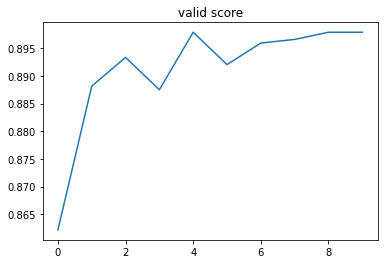

========== training ==========
========== training ==========


Epoch: [1][1/192] Data 1.403 (1.403) Elapsed 0m 2s (remain 6m 35s) Loss: 0.6770(0.6770) Grad: 30.0714  
Epoch: [1][101/192] Data 0.001 (0.015) Elapsed 0m 34s (remain 0m 31s) Loss: 0.5127(0.5295) Grad: 26.3549  
Epoch: [1][192/192] Data 0.000 (0.008) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4615(0.4576) Grad: 26.2680  
EVAL: [1/49] Data 0.772 (0.772) Elapsed 0m 0s (remain 0m 46s) Loss: 0.4153(0.4153) 
EVAL: [49/49] Data 0.000 (0.018) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1580(0.3597) 


Epoch 1 - avg_train_loss: 0.4576  avg_val_loss: 0.3597  time: 68s
Epoch 1 - avg_train_loss: 0.4576  avg_val_loss: 0.3597  time: 68s
Epoch 1 - Accuracy: 0.8686605981794538
Epoch 1 - Accuracy: 0.8686605981794538
Epoch 1 - Save Best Score: 0.8687 Model
Epoch 1 - Save Best Score: 0.8687 Model


Epoch: [2][1/192] Data 2.908 (2.908) Elapsed 0m 3s (remain 11m 7s) Loss: 0.2886(0.2886) Grad: 13.8762  
Epoch: [2][101/192] Data 0.001 (0.029) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3695(0.3644) Grad: 25.8886  
Epoch: [2][192/192] Data 0.000 (0.016) Elapsed 1m 2s (remain 0m 0s) Loss: 0.4710(0.3381) Grad: 23.6198  
EVAL: [1/49] Data 1.099 (1.099) Elapsed 0m 1s (remain 0m 58s) Loss: 0.2360(0.2360) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 4s (remain 0m 0s) Loss: 0.1270(0.2912) 


Epoch 2 - avg_train_loss: 0.3381  avg_val_loss: 0.2912  time: 68s
Epoch 2 - avg_train_loss: 0.3381  avg_val_loss: 0.2912  time: 68s
Epoch 2 - Accuracy: 0.8914174252275683
Epoch 2 - Accuracy: 0.8914174252275683
Epoch 2 - Save Best Score: 0.8914 Model
Epoch 2 - Save Best Score: 0.8914 Model


Epoch: [3][1/192] Data 2.631 (2.631) Elapsed 0m 3s (remain 10m 1s) Loss: 0.2697(0.2697) Grad: 14.2806  
Epoch: [3][101/192] Data 0.000 (0.027) Elapsed 0m 34s (remain 0m 31s) Loss: 0.4436(0.3200) Grad: 20.1315  
Epoch: [3][192/192] Data 0.000 (0.014) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3279(0.2949) Grad: 21.3586  
EVAL: [1/49] Data 1.210 (1.210) Elapsed 0m 1s (remain 1m 3s) Loss: 0.2003(0.2003) 
EVAL: [49/49] Data 0.000 (0.026) Elapsed 0m 5s (remain 0m 0s) Loss: 0.0871(0.2921) 


Epoch 3 - avg_train_loss: 0.2949  avg_val_loss: 0.2921  time: 68s
Epoch 3 - avg_train_loss: 0.2949  avg_val_loss: 0.2921  time: 68s
Epoch 3 - Accuracy: 0.8953185955786735
Epoch 3 - Accuracy: 0.8953185955786735
Epoch 3 - Save Best Score: 0.8953 Model
Epoch 3 - Save Best Score: 0.8953 Model


Epoch: [4][1/192] Data 2.182 (2.182) Elapsed 0m 2s (remain 8m 19s) Loss: 0.2132(0.2132) Grad: 15.1694  
Epoch: [4][101/192] Data 0.001 (0.023) Elapsed 0m 34s (remain 0m 30s) Loss: 0.4569(0.2937) Grad: 26.5550  
Epoch: [4][192/192] Data 0.000 (0.012) Elapsed 1m 1s (remain 0m 0s) Loss: 0.2812(0.2723) Grad: 19.4338  
EVAL: [1/49] Data 1.104 (1.104) Elapsed 0m 1s (remain 0m 58s) Loss: 0.2682(0.2682) 
EVAL: [49/49] Data 0.000 (0.024) Elapsed 0m 5s (remain 0m 0s) Loss: 0.3335(0.2943) 


Epoch 4 - avg_train_loss: 0.2723  avg_val_loss: 0.2943  time: 67s
Epoch 4 - avg_train_loss: 0.2723  avg_val_loss: 0.2943  time: 67s
Epoch 4 - Accuracy: 0.8953185955786735
Epoch 4 - Accuracy: 0.8953185955786735


Epoch: [5][1/192] Data 1.668 (1.668) Elapsed 0m 2s (remain 6m 55s) Loss: 0.2427(0.2427) Grad: 13.7222  
Epoch: [5][101/192] Data 0.000 (0.017) Elapsed 0m 34s (remain 0m 30s) Loss: 0.3772(0.2705) Grad: 17.8980  
Epoch: [5][192/192] Data 0.000 (0.009) Elapsed 1m 1s (remain 0m 0s) Loss: 0.2479(0.2470) Grad: 14.4134  
EVAL: [1/49] Data 1.499 (1.499) Elapsed 0m 1s (remain 1m 23s) Loss: 0.2366(0.2366) 
EVAL: [49/49] Data 0.000 (0.032) Elapsed 0m 5s (remain 0m 0s) Loss: 0.1497(0.2921) 


Epoch 5 - avg_train_loss: 0.2470  avg_val_loss: 0.2921  time: 68s
Epoch 5 - avg_train_loss: 0.2470  avg_val_loss: 0.2921  time: 68s
Epoch 5 - Accuracy: 0.8992197659297789
Epoch 5 - Accuracy: 0.8992197659297789
Epoch 5 - Save Best Score: 0.8992 Model
Epoch 5 - Save Best Score: 0.8992 Model


Epoch: [6][1/192] Data 1.759 (1.759) Elapsed 0m 2s (remain 7m 37s) Loss: 0.1642(0.1642) Grad: 12.0145  
Epoch: [6][101/192] Data 0.001 (0.018) Elapsed 0m 34s (remain 0m 31s) Loss: 0.4177(0.2447) Grad: 27.9372  
Epoch: [6][192/192] Data 0.000 (0.010) Elapsed 1m 2s (remain 0m 0s) Loss: 0.2771(0.2206) Grad: 18.1309  
EVAL: [1/49] Data 0.804 (0.804) Elapsed 0m 0s (remain 0m 45s) Loss: 0.2284(0.2284) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.3027(0.2912) 


Epoch 6 - avg_train_loss: 0.2206  avg_val_loss: 0.2912  time: 67s
Epoch 6 - avg_train_loss: 0.2206  avg_val_loss: 0.2912  time: 67s
Epoch 6 - Accuracy: 0.8985695708712613
Epoch 6 - Accuracy: 0.8985695708712613


Epoch: [7][1/192] Data 2.358 (2.358) Elapsed 0m 2s (remain 9m 26s) Loss: 0.1397(0.1397) Grad: 13.0262  
Epoch: [7][101/192] Data 0.000 (0.024) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3467(0.2109) Grad: 21.7206  
Epoch: [7][192/192] Data 0.000 (0.013) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1727(0.1904) Grad: 16.2522  
EVAL: [1/49] Data 0.688 (0.688) Elapsed 0m 0s (remain 0m 42s) Loss: 0.1957(0.1957) 
EVAL: [49/49] Data 0.000 (0.020) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2251(0.2932) 


Epoch 7 - avg_train_loss: 0.1904  avg_val_loss: 0.2932  time: 68s
Epoch 7 - avg_train_loss: 0.1904  avg_val_loss: 0.2932  time: 68s
Epoch 7 - Accuracy: 0.8966189856957087
Epoch 7 - Accuracy: 0.8966189856957087


Epoch: [8][1/192] Data 2.259 (2.259) Elapsed 0m 2s (remain 9m 3s) Loss: 0.1220(0.1220) Grad: 10.9352  
Epoch: [8][101/192] Data 0.000 (0.023) Elapsed 0m 34s (remain 0m 31s) Loss: 0.3299(0.1968) Grad: 20.1096  
Epoch: [8][192/192] Data 0.000 (0.012) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1307(0.1763) Grad: 14.3067  
EVAL: [1/49] Data 0.748 (0.748) Elapsed 0m 0s (remain 0m 42s) Loss: 0.2207(0.2207) 
EVAL: [49/49] Data 0.000 (0.019) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2480(0.2936) 


Epoch 8 - avg_train_loss: 0.1763  avg_val_loss: 0.2936  time: 68s
Epoch 8 - avg_train_loss: 0.1763  avg_val_loss: 0.2936  time: 68s
Epoch 8 - Accuracy: 0.8959687906371911
Epoch 8 - Accuracy: 0.8959687906371911


Epoch: [9][1/192] Data 1.674 (1.674) Elapsed 0m 2s (remain 6m 59s) Loss: 0.1207(0.1207) Grad: 10.0278  
Epoch: [9][101/192] Data 0.001 (0.017) Elapsed 0m 34s (remain 0m 30s) Loss: 0.1783(0.1754) Grad: 12.6430  
Epoch: [9][192/192] Data 0.000 (0.009) Elapsed 1m 2s (remain 0m 0s) Loss: 0.1878(0.1571) Grad: 20.9080  
EVAL: [1/49] Data 0.876 (0.876) Elapsed 0m 1s (remain 0m 48s) Loss: 0.2145(0.2145) 
EVAL: [49/49] Data 0.000 (0.022) Elapsed 0m 4s (remain 0m 0s) Loss: 0.2324(0.2969) 


Epoch 9 - avg_train_loss: 0.1571  avg_val_loss: 0.2969  time: 68s
Epoch 9 - avg_train_loss: 0.1571  avg_val_loss: 0.2969  time: 68s
Epoch 9 - Accuracy: 0.8979193758127438
Epoch 9 - Accuracy: 0.8979193758127438


Epoch: [10][1/192] Data 1.860 (1.860) Elapsed 0m 2s (remain 7m 45s) Loss: 0.1349(0.1349) Grad: 11.9821  
Epoch: [10][101/192] Data 0.000 (0.020) Elapsed 0m 34s (remain 0m 30s) Loss: 0.2758(0.1582) Grad: 21.1126  
Epoch: [10][192/192] Data 0.000 (0.011) Elapsed 1m 2s (remain 0m 0s) Loss: 0.3225(0.1462) Grad: 31.3268  
EVAL: [1/49] Data 1.286 (1.286) Elapsed 0m 1s (remain 1m 5s) Loss: 0.2117(0.2117) 
EVAL: [49/49] Data 0.000 (0.027) Elapsed 0m 5s (remain 0m 0s) Loss: 0.2591(0.2991) 


Epoch 10 - avg_train_loss: 0.1462  avg_val_loss: 0.2991  time: 68s
Epoch 10 - avg_train_loss: 0.1462  avg_val_loss: 0.2991  time: 68s
Epoch 10 - Accuracy: 0.8972691807542262
Epoch 10 - Accuracy: 0.8972691807542262
========== CV ==========
========== CV ==========
Score: 0.89922
Score: 0.89922


TN 1106
FP 45
FN 110
TP 277


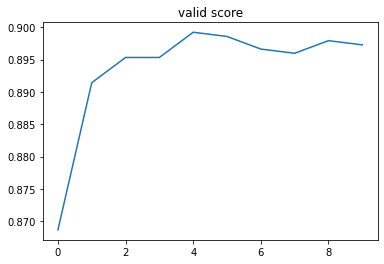

In [25]:
if __name__ == '__main__':
    for i in range(5):
        main(i)